In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
import joblib

from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

from tqdm.auto import tqdm

In [5]:
path_input = 'combined_news_data.csv'
df = pd.read_csv(path_input, lineterminator='\n')

# Remove the extra sentence from each row
#df['sentence'] = df['sentence'].apply(lambda x: x.split('ترجمة')[0] if 'ترجمة' in x else x)

df.head()

,sentence,label
0,وفقًا لجران، ليس لدى الشركة أي خطط لنقل جميع ا...,1
1,تخطط تكنوبوليس لتطوير منطقة بمساحة لا تقل عن 1...,1
2,شركة الكترونيات عالمية تدعى الكوتيك قامت بفصل ...,0
3,بفضل المصنع الإنتاجي الجديد، ستتمكن الشركة من ...,2
4,وفقًا لاستراتيجية الشركة المحدثة للسنوات 2009-...,2


In [6]:
train, val = train_test_split(df, test_size=0.1, random_state=42)

train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)

In [7]:
class ArabicDataset(Dataset):
    def __init__(self,data,max_len):
        super().__init__()
        self.labels = data["label"].values
        self.texts = data["sentence"].values
        self.max_len = max_len
        model = 'aubmindlab/bert-base-arabertv2'
        self.tokenizer = AutoTokenizer.from_pretrained(model)

    def __len__(self):
        return len(str(self.texts))

    def __getitem__(self,idx):
        text = " ".join(self.texts[idx].split())
        label = self.labels[idx]
        inputs = self.tokenizer(text,padding='max_length',
                                max_length=self.max_len,truncation=True,return_tensors="pt")
        #input_ids,token_type_ids,attention_mask
        return {
            "inputs":{"input_ids":inputs["input_ids"][0],
                      "token_type_ids":inputs["token_type_ids"][0],
                      "attention_mask":inputs["attention_mask"][0],
                     },
            "labels": torch.tensor(label,dtype=torch.long)
        }

In [8]:
class ArabicDataModule(pl.LightningDataModule):
    def __init__(self,train_path,val_path,batch_size=12,max_len=100):
        super().__init__()
        self.train_path,self.val_path= train_path,val_path
        self.batch_size = batch_size
        self.max_len = max_len


    def setup(self,stage=None):
        train = pd.read_csv(self.train_path)
        val = pd.read_csv(self.val_path)
        self.train_dataset = ArabicDataset(data=train,max_len=self.max_len)
        self.val_dataset = ArabicDataset(data=val,max_len=self.max_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False)

In [9]:
n_classes = 3
class ArabicBertModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model = "aubmindlab/bert-base-arabertv2"
        self.bert_model = AutoModel.from_pretrained(model)
        self.fc = nn.Linear(768, n_classes)

    def forward(self,inputs):
        out = self.bert_model(**inputs)#inputs["input_ids"],inputs["token_type_ids"],inputs["attention_mask"])
        last_hidden_states = out[1]
        out = self.fc(last_hidden_states)
        return out

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

    def criterion(self,output,target):
        return nn.CrossEntropyLoss()(output,target)

    #TODO: adding metrics
    def training_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        metrics = {"train_loss": loss}
        self.log_dict(metrics)
        return loss

    def validation_step(self,batch,batch_idx):
        x, y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        metrics = {"val_loss": loss}
        self.log_dict(metrics)
        return metrics

In [ ]:

dm = ArabicDataModule(train_path="train.csv",
                val_path = "val.csv",
                batch_size=128, max_len=90)

model = ArabicBertModel()
trainer = pl.Trainer(max_epochs=10, default_root_dir='.') #callbacks=[EarlyStopping(monitor="val_f1")]
trainer.fit(model,dm)

In [ ]:
torch.save(model, 'arabert_financialnews_sentimentanalysis.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('arabert_financialnews_sentimentanalysis.pth',  map_location=device)
model.to(device)

preds = []
real_values = []

test_dataloader = dm.test_dataloader()

progress_bar = tqdm(range(len(test_dataloader)))

model.eval()
for batch in test_dataloader:
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}

    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=1)

    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()

preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()
print(classification_report(real_values, preds, target_names=['0', '1', '2']))

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  15716 MiB |  15716 MiB |  92770 MiB |  77053 MiB |\n|       from large pool |  15713 MiB |  15713 MiB |  92553 MiB |  76840 MiB |\n|       from small pool |      3 MiB |      4 MiB |    216 MiB |    213 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  15716 MiB |  15716 MiB |  92770 MiB |  77053 MiB |\n|       from large pool |  15713 MiB |  15713 MiB |

In [10]:
combined_news_data = df

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_for_finetuning = torch.load('/content/drive/MyDrive/arabert_financialnews_sentimentanalysis.pth', map_location=device)
model_for_finetuning.to(device)


ArabicBertModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
combined_dm = ArabicDataModule(train_path="train.csv", val_path="val.csv", batch_size=32, max_len=512)

In [12]:
logger = pl_loggers.TensorBoardLogger(save_dir='logs/', name='finetuned_finarabert')
trainer_finetune = pl.Trainer(max_epochs=100, default_root_dir='.', logger=logger)
trainer_finetune.fit(model_for_finetuning, combined_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert_model | BertModel | 135 M 
1 | fc         | Linear    | 2.3 K 
-----------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
540.783   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value 

Training: 0it [00:00, ?it/s]

OutOfMemoryError: ignored

In [ ]:
torch.save(model_for_finetuning, 'fine_tuned_finarabert.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_for_finetuning = torch.load('fine_tuned_finarabert.pth', map_location=device)
model_for_finetuning.to(device)

preds = []
real_values = []

test_dataloader = combined_dm.test_dataloader()  # Use the test dataloader from the combined data module

progress_bar = tqdm(range(len(test_dataloader)))

model_for_finetuning.eval()
for batch in test_dataloader:
    x, y = batch["inputs"], batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}

    with torch.no_grad():
        outputs = model_for_finetuning(inp)

    predictions = torch.argmax(outputs, dim=1)

    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()

preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()
print(classification_report(real_values, preds, target_names=['0', '1', '2']))


  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.47      0.56      0.51        73
           1       0.77      0.71      0.74       306
           2       0.61      0.65      0.63       169

    accuracy                           0.67       548
   macro avg       0.62      0.64      0.63       548
weighted avg       0.68      0.67      0.67       548



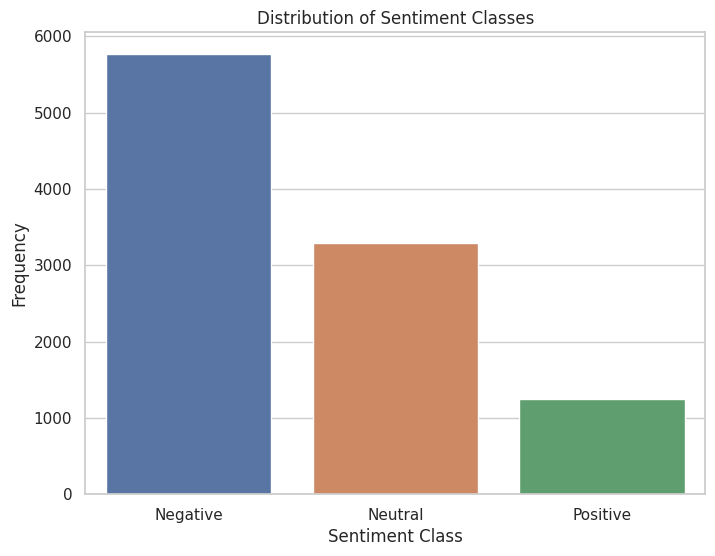

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'combined_news_data' contains your combined dataset
class_counts = combined_news_data['label'].value_counts()

# Define class labels for visualization
class_labels = ['Negative', 'Neutral', 'Positive']

# Create a bar plot for class distribution
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_labels, y=class_counts)
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Sentiment Classes')
plt.show()
